In [14]:
from itertools import combinations

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [44]:
def mww_test_between_sentiment(data, category_column):
    unique_categories = data[category_column].unique()
    
    results = []
    
    for category in unique_categories:
        positive_data = data[data[category_column] == category]['sentiment_score_positive']
        negative_data = data[data[category_column] == category]['sentiment_score_negative']
        
        u_statistic, p_value = mannwhitneyu(positive_data, negative_data)
        
        results.append({
            f'{category_column}': category,
            'u_statistic': u_statistic,
            'p_value': p_value
        })
        
    return pd.DataFrame(results)

def mww_test_between_categories(data, category_column):
    unique_categories = data[category_column].unique()
    
    results = []
    
    for category1, category2 in combinations(unique_categories, 2):
        category1_data = data[data[category_column] == category1]['sentiment_score_cumulative']
        category2_data = data[data[category_column] == category2]['sentiment_score_cumulative']
        
        u_statistic, p_value = mannwhitneyu(category1_data, category2_data)
        
        results.append({
            f'{category_column}1': category1,
            f'{category_column}2': category2,
            'u_statistic': u_statistic,
            'p_value': p_value
        })
        
    return pd.DataFrame(results)

# RQ 3 + 4

In [45]:
rq34 = pd.read_csv("./data/rq_3_4.csv")
print(len(rq34))

3814162


In [46]:
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
rq34['sentiment_score'] = rq34['text_sentiment'].map(sentiment_mapping)
 
rq34['is_negative'] = rq34['text_sentiment'] == 'negative'
rq34['is_positive'] = rq34['text_sentiment'] == 'positive'
rq34['is_neutral'] = rq34['text_sentiment'] == 'neutral'

# rq34['is_bug'] = rq34['issuetype'] == 'bug'
# rq34['is_nonbug'] = rq34['issuetype'] != 'bug'
# 
# rq34['is_blocker'] = rq34['priority'] == 'Blocker'
# rq34['is_critical'] = rq34['priority'] == 'Critical'
# rq34['is_major'] = rq34['priority'] == 'Major'
# rq34['is_minor'] = rq34['priority'] == 'Minor'
# rq34['is_trivial'] = rq34['priority'] == 'Trivial'

cumulative_scores = rq34.groupby('issue_id')['sentiment_score'].sum().reset_index()
positive_scores = rq34.groupby('issue_id')['is_positive'].sum().reset_index()
negative_scores = rq34.groupby('issue_id')['is_negative'].sum().reset_index()

rq34 = rq34.merge(cumulative_scores, on='issue_id', suffixes=('', '_cumulative'))
rq34 = rq34.merge(positive_scores, on='issue_id', suffixes=('', '_count'))
rq34 = rq34.rename(columns={'is_positive_count': 'sentiment_score_positive'})
rq34 = rq34.merge(negative_scores, on='issue_id', suffixes=('', '_count'))
rq34 = rq34.rename(columns={'is_negative_count': 'sentiment_score_negative'})

assert len(rq34[rq34['sentiment_score_cumulative'] != rq34['sentiment_score_positive'] - rq34['sentiment_score_negative']]) == 0
print(len(rq34))
rq34.sample(10)

3814162


,text_sentiment,product,issue_id,comment_id,priority,issuetype,sentiment_score,is_negative,is_positive,is_neutral,sentiment_score_cumulative,sentiment_score_positive,sentiment_score_negative
581789,neutral,DERBY,12327853.0,12489867.0,Major,non-bug,0,False,False,True,9,31,22
3592074,neutral,QPID,12854090.0,14681821.0,Major,bug,0,False,False,True,1,1,0
492442,neutral,COMMONSSITE,12384365.0,12556979.0,Major,non-bug,0,False,False,True,-12,5,17
94768,negative,AMBARI,12931553.0,15105891.0,Critical,bug,-1,True,False,False,-1,1,2
598732,negative,DERBY,12372581.0,12509297.0,Major,bug,-1,True,False,False,-2,1,3
1879149,positive,IGNITE,12784779.0,14483267.0,Major,bug,1,False,True,False,0,1,1
2662754,positive,OFBIZ,12434942.0,12773692.0,Minor,bug,1,False,True,False,0,4,4
5808,neutral,ACCUMULO,12637621.0,13760440.0,Major,bug,0,False,False,True,-1,0,1
3763303,positive,OOZIE,13032566.0,15813565.0,Minor,non-bug,1,False,True,False,10,14,4
1213865,positive,HARMONY,12400585.0,12614965.0,Minor,non-bug,1,False,True,False,4,4,0


In [47]:
rq34.columns

Index(['text_sentiment', 'product', 'issue_id', 'comment_id', 'priority',
       'issuetype', 'sentiment_score', 'is_negative', 'is_positive',
       'is_neutral', 'sentiment_score_cumulative', 'sentiment_score_positive',
       'sentiment_score_negative'],
      dtype='object')

In [48]:
# make a table for only the individual issues

rq34_issues = rq34.drop_duplicates(subset='issue_id')
rq34_issues = rq34_issues[['issue_id', 'product', 'issuetype', 'priority', 'sentiment_score_cumulative', 'sentiment_score_positive', 'sentiment_score_negative']]

print(len(rq34_issues))
rq34_issues.sample(10)

716852


,issue_id,product,issuetype,priority,sentiment_score_cumulative,sentiment_score_positive,sentiment_score_negative
794765,12582714.0,FLEX,bug,Major,-2,0,2
394284,12418499.0,CAY,non-bug,Major,-1,0,1
335773,13073037.0,CALCITE,non-bug,Major,1,1,0
2474544,12794299.0,MNG,bug,Major,-1,0,1
3281154,13039261.0,SPARK,non-bug,Major,-1,0,1
161938,12458985.0,ARIES,bug,Major,1,1,0
1904129,13144274.0,IGNITE,bug,Major,0,0,0
3174365,12897950.0,SVN,bug,Minor,1,1,0
3511255,12447164.0,SHALE,non-bug,Major,1,1,0
2436691,13024733.0,MESOS,bug,Major,-2,0,2


In [50]:
rq34_issues.describe()

,issue_id,sentiment_score_cumulative,sentiment_score_positive,sentiment_score_negative
count,7.168520e+05,716852.000000,716852.000000,716852.000000
mean,1.266683e+07,0.392914,1.312880,0.919967
std,1.273344e+06,2.068155,2.372866,1.915565
min,1.001200e+04,-194.000000,0.000000,0.000000
25%,1.253991e+07,0.000000,0.000000,0.000000
50%,1.277318e+07,0.000000,1.000000,0.000000
75%,1.303514e+07,1.000000,2.000000,1.000000
max,1.328057e+07,109.000000,157.000000,194.000000


## RQ 3 chi-square

In [28]:
rq3_contingency_table = pd.crosstab(rq34['issuetype'], rq34['text_sentiment'])
rq3_contingency_table

text_sentiment,negative,neutral,positive
issuetype,,,
bug,376168,1032756,467624
non-bug,283312,1180785,473517


In [29]:
chi2, p, dof, expected = stats.chi2_contingency(rq3_contingency_table)

print(f"\nChi-Square Test Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)


Chi-Square Test Statistic: 22038.492955364705
p-value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[ 324460.75311956 1089050.7368245   463036.51005594]
 [ 335019.24688044 1124490.2631755   478104.48994406]]


In [30]:
observed = rq3_contingency_table.values
residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(residuals, index=rq3_contingency_table.index, columns=rq3_contingency_table.columns)

print("\nStandardized Residuals:")
print(residuals_df)


Standardized Residuals:
text_sentiment   negative    neutral  positive
issuetype                                     
bug             90.775851 -53.944073  6.741670
non-bug        -89.333950  53.087215 -6.634584


## RQ 3 mww

In [58]:
mww_test_between_categories(rq34_issues, 'issuetype')

,issuetype1,issuetype2,u_statistic,p_value
0,bug,non-bug,5.790537e+10,0.0


In [59]:
mww_test_between_sentiment(rq34_issues, 'issuetype')

,issuetype,u_statistic,p_value
0,bug,8.365786e+10,0.0
1,non-bug,6.203427e+10,0.0


## RQ 4 chi-square

In [18]:
rq4_contingency_table = pd.crosstab(rq34['priority'], rq34['text_sentiment'])
rq4_contingency_table

text_sentiment,negative,neutral,positive
priority,,,
Blocker,39716,102122,44046
Critical,49265,134894,55221
Major,439509,1531149,638294
Minor,117301,393634,177164
Trivial,13689,51742,26416


In [19]:
# Perform the Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(rq4_contingency_table)

print(f"\nChi-Square Test Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)


Chi-Square Test Statistic: 5961.983421818359
p-value: 0.0
Degrees of Freedom: 8
Expected Frequencies:
[[  32139.89870383  107877.39357793   45866.70771824]
 [  41389.51685849  138923.68614128   59066.79700023]
 [ 451095.59189148 1514099.87804189  643756.53006663]
 [ 118974.37196427  399336.82642714  169787.80160858]
 [  15880.62058193   53303.21581176   22663.16360632]]


In [21]:
observed = rq4_contingency_table.values
residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(residuals, index=rq4_contingency_table.index, columns=rq4_contingency_table.columns)

print("\nStandardized Residuals:")
print(residuals_df)


Standardized Residuals:
text_sentiment   negative    neutral   positive
priority                                       
Blocker         42.259419 -17.523054  -8.501420
Critical        38.710789 -10.811428 -15.823941
Major          -17.251284  13.855581  -6.808211
Minor           -4.851385  -9.024444  17.901085
Trivial        -17.391284  -6.762172  24.928685


## RQ 4 mww

In [56]:
mww_test_between_categories(rq34_issues, 'priority')

,priority1,priority2,u_statistic,p_value
0,Major,Minor,3.580058e+10,2.328685e-02
1,Major,Blocker,6.800420e+09,4.082549e-92
2,Major,Trivial,5.103691e+09,8.469316e-113
3,Major,Critical,9.338855e+09,1.413028e-115
4,Minor,Blocker,2.111651e+09,4.999598e-93
5,Minor,Trivial,1.582682e+09,9.786769e-97
6,Minor,Critical,2.899938e+09,2.917191e-113
7,Blocker,Trivial,2.587772e+08,5.101650e-193
8,Blocker,Critical,4.752619e+08,5.036036e-01
9,Trivial,Critical,4.820324e+08,2.570175e-223


In [57]:
mww_test_between_sentiment(rq34_issues, 'priority')

,priority,u_statistic,p_value
0,Major,1.313023e+11,0.000000e+00
1,Minor,1.270779e+10,0.000000e+00
2,Blocker,3.592775e+08,5.765093e-15
3,Trivial,3.378914e+08,0.000000e+00
4,Critical,6.855561e+08,1.244650e-28


# Visualizations

In [9]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [10]:
plt.style.use('seaborn-v0_8-ticks')

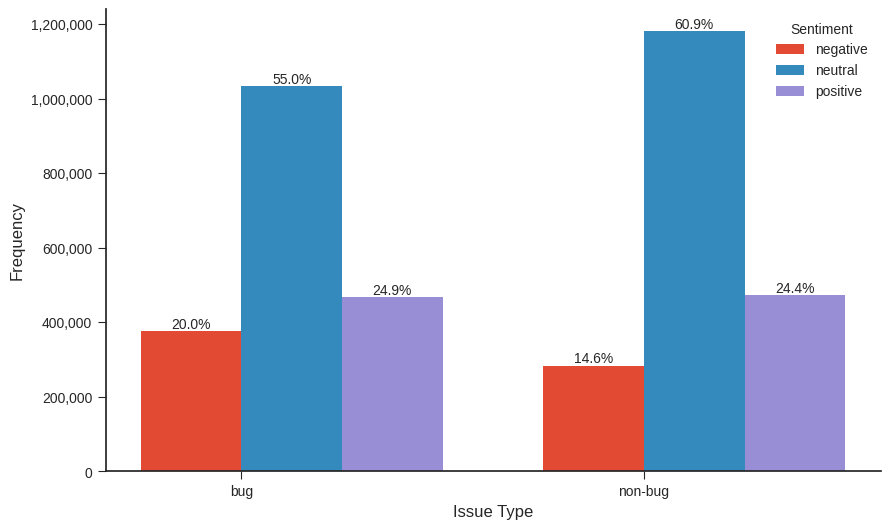

In [87]:
grouped = rq34.groupby(['issuetype', 'text_sentiment']).size().unstack(fill_value=0)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))  

sentiments = grouped.columns
issue_types = grouped.index

bar_width = 0.25
bar_positions = list(range(len(issue_types)))

for i, sentiment in enumerate(sentiments):
    offset = i * bar_width - bar_width / 2

    bars = plt.bar([pos + offset for pos in bar_positions], grouped[sentiment], width=bar_width, label=sentiment)
    
    for bar, pct in zip(bars, grouped_percent[sentiment]):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)


# Customize plot
plt.xlabel('Issue Type')
plt.ylabel('Frequency')
# plt.title('Sentiment Frequencies by Issue Type')
plt.xticks(bar_positions, issue_types)
plt.legend(title='Sentiment', loc='upper right')
plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False)  
plt.gca().get_xaxis().tick_bottom() 
plt.gca().get_yaxis().tick_left()  
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(False)
plt.show()

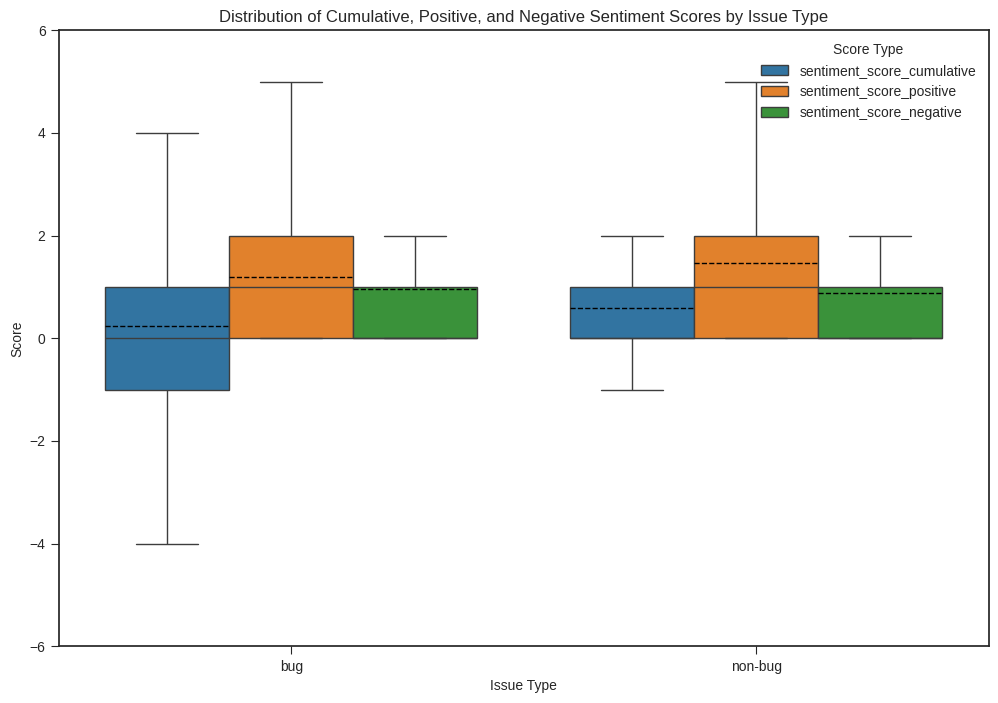

In [70]:
df = rq34_issues

melted = pd.melt(
    df,
    id_vars=['issuetype'],
    value_vars=['sentiment_score_cumulative', 'sentiment_score_positive', 'sentiment_score_negative'],
    var_name='score_type',
    value_name='score'
)

plt.figure(figsize=(12, 8))
sns.boxplot(x='issuetype', y='score', hue='score_type', data=melted, showmeans=True, meanline=True, fliersize=0,
            meanprops={'linestyle': '--', 'linewidth': 1, 'color': 'k'})
plt.title('Distribution of Cumulative, Positive, and Negative Sentiment Scores by Issue Type')
plt.xlabel('Issue Type')
plt.ylabel('Score')
plt.ylim(-6, 6)
plt.legend(title='Score Type', loc='upper right')
plt.show()

# draw a box plot to show the distribution of cumulative, positive, negative sentiment score by issue type.

# plt.figure(figsize=(10, 6))
# 
# grouped = rq34.groupby(['issuetype', 'sentiment_score_cumulative', 'sentiment_score_positive', 'sentiment_score_negative']).size().reset_index(name='count')
# 
# # Melt the dataframe for easy plotting
# melted = pd.melt(grouped, id_vars='issuetype', value_vars=['sentiment_score_positive', 'sentiment_score_negative', 'sentiment_score_cumulative'], var_name='score_type', value_name='score')
# 
# # Create the box plot
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='score_type', y='score', hue='issuetype', data=melted)
# plt.title('Distribution of Cumulative, Positive, and Negative Sentiment Scores by Issue Type')
# plt.xlabel('Score Type')
# plt.ylabel('Score')
# plt.legend(title='Issue Type')
# plt.show()
# 



# plt.figure(figsize=(10, 6))
# 
# boxplot = rq34.boxplot(column=['sentiment_score_cumulative', 'sentiment_score_positive', 'sentiment_score_negative'], by='issuetype', figsize=(10, 6))
# 
# plt.xlabel('Issue Type')
# plt.ylabel('Sentiment Score')
# # plt.title('Sentiment Score Distribution by Issue Type')
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().get_xaxis().tick_bottom()
# plt.gca().get_yaxis().tick_left()
# plt.show()

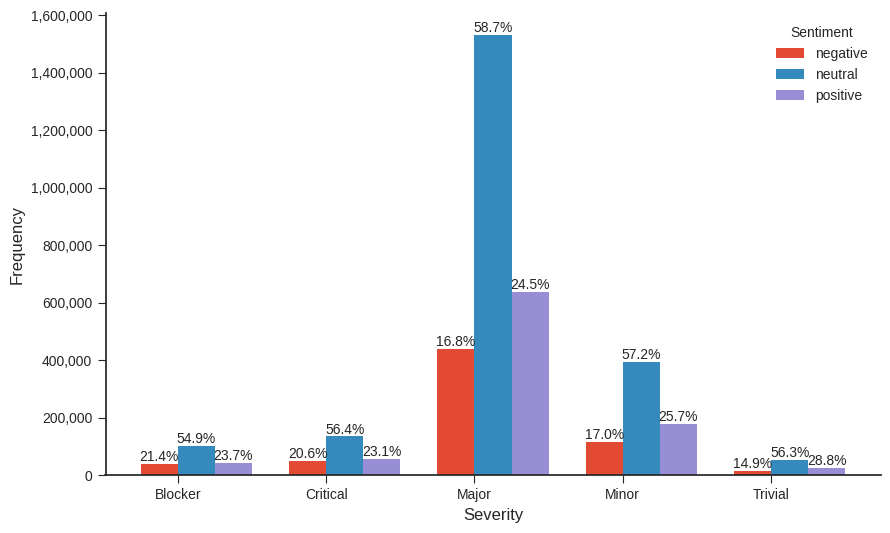

In [96]:
grouped = rq34.groupby(['priority', 'text_sentiment']).size().unstack(fill_value=0)
grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))  

priorities = grouped.columns
issue_types = grouped.index

bar_width = 0.25
bar_positions = list(range(len(issue_types)))

for i, priority in enumerate(priorities):
    offset = i * bar_width - bar_width / 2

    bars = plt.bar([pos + offset for pos in bar_positions], grouped[priority], width=bar_width, label=priority)
    
    for bar, pct in zip(bars, grouped_percent[priority]):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

# Customize plot
plt.xlabel('Severity')
plt.ylabel('Frequency')
# plt.title('Sentiment Frequencies by Issue Priority')
plt.xticks(bar_positions, issue_types)
plt.legend(title='Sentiment', loc='upper right')
plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False)  
plt.gca().get_xaxis().tick_bottom() 
plt.gca().get_yaxis().tick_left()  
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(False)
plt.show()

In [89]:
mean_cumulative_scores = rq34.groupby('priority')['sentiment_score_cumulative'].mean().reset_index()
mean_positive_scores = rq34.groupby('priority')['sentiment_score_positive'].mean().reset_index()
mean_negative_scores = rq34.groupby('priority')['sentiment_score_negative'].mean().reset_index()

mean_scores = mean_cumulative_scores.merge(mean_positive_scores, on='priority')
mean_scores = mean_scores.merge(mean_negative_scores, on='priority')
mean_scores

,priority,sentiment_score_cumulative,sentiment_score_positive,sentiment_score_negative
0,Blocker,0.248564,5.131044,4.882480
1,Critical,0.550576,5.048442,4.497865
2,Major,1.257710,4.421778,3.164068
3,Minor,1.055568,3.632485,2.576917
4,Trivial,1.082518,2.599562,1.517045


In [12]:
# plt.figure(figsize=(10, 6))
# 
# bar_width = 0.25
# bar_positions = list(range(len(mean_scores)))
# 
# plt.bar([pos - bar_width for pos in bar_positions], mean_scores['sentiment_score_cumulative'], width=bar_width, label='Cumulative')
# plt.bar(bar_positions, mean_scores['sentiment_score_positive'], width=bar_width, label='Positive')
# plt.bar([pos + bar_width for pos in bar_positions], mean_scores['sentiment_score_negative'], width=bar_width, label='Negative')
# 
# plt.xlabel('Severity')
# plt.ylabel('Mean Sentiment Score')
# # plt.title('Mean Sentiment Scores by Priority')
# plt.gca().spines['top'].set_visible(False) 
# plt.gca().spines['right'].set_visible(False)  
# plt.xticks(bar_positions, mean_scores['priority'])
# plt.legend()
# plt.show()